### SEGAN without the GAN

In [1]:
import os
import torch
import re
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import SpeechDataset
import time
from another_model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from losses import weightedSDR

In [2]:
torchaudio.set_audio_backend('sox_io')

In [3]:
if torch.backends.cudnn.enabled and torch.cuda.is_available():
    print('CUDA is ready!')

CUDA is ready!


In [4]:
num_epochs = 400
batch_size = 1024
learning_rate = 1e-4

In [5]:
preload_model_from_weights = False
overfit_one_batch = True
limit_samples = batch_size if overfit_one_batch else 0

In [6]:
if preload_model_from_weights:
    epochs = filter(lambda x: re.search("^seae_epoch_\d+\.pth$", x), os.listdir('models'))
    epochs = map(lambda x: int(re.search("^seae_epoch_(\d+)\.pth$", x)[1]), epochs)
    last_epoch = max(epochs)
else:
    last_epoch = 0

In [7]:
if int(last_epoch) > 0: MODEL_PATH = f'models/seae_epoch_{last_epoch}.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [8]:
dataset = SpeechDataset(clean_dir='data/clean/',
                        noise_dir='data/noise/', 
                        window_size=8192, 
                        overlap=50,
                        snr=1
                       )

In [9]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## The training

In [10]:
model = Autoencoder(depth = 10, bs=batch_size, pay_attention=True).cuda()

In [14]:
model.load_state_dict(torch.load('models/was_kinda_good_mse.pth'))

<All keys matched successfully>

In [15]:
lrs = [(20, 1e-5), (100, 1e-3), (50, 1e-4)]

In [ ]:
for num_epochs, learning_rate in lrs:
    if preload_model_from_weights:
        model.load_state_dict(torch.load(MODEL_PATH))
        last_epoch = 0

    criterion = weightedSDR
    #criterion = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    model.train()

    pbar = tqdm()
    pbar.reset(total=(len(dataset) // batch_size))

    for epoch in trange(num_epochs):
        print_epoch = epoch % 5 == 0
        save_state = print_epoch

        if print_epoch: print(f'Starting epoch {epoch + 1 + last_epoch}')


        for i, data in enumerate(dataloader):
            inp = data[0].clone().detach().cuda()
            expected = data[1].clone().detach().cuda()
            output = model(inp)
            loss = criterion(output, expected, inp)
            #los = criterion(output, expected)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #pbar.update()    

        pbar.refresh()
        if save_state:
            torch.save(model.state_dict(), f'models/noisy_seae_epoch_{epoch + last_epoch + 1}.pth')

        if print_epoch:
            print(f'epoch [{epoch}/{num_epochs}]')
            print(round(loss.item(), 5))

Starting epoch 1
epoch [0/20]
-0.98483
Starting epoch 6
epoch [5/20]
-0.98486
Starting epoch 11
epoch [10/20]
-0.98559
Starting epoch 16
epoch [15/20]
-0.98552



Starting epoch 1
epoch [0/100]
-0.94161
Starting epoch 6
epoch [5/100]
-0.96098


## Looking (listening) to the results

In [13]:
pesqs = []

#data = next(iter(dataloader))
model.eval()
with torch.no_grad():
    sample = data[1].cuda()
    inp = data[0]
    output = model(data[0].cuda())
    
    for i, _s in enumerate(sample[:500]):
        ref = output[i, :, :].cpu().detach().numpy().T[:, 0]
        target = sample[i, :, :].cpu().detach().numpy().T[:, 0]
        noised = inp[i, :, :].cpu().detach().numpy().T[:, 0]
        
        val = pesq(target, ref, 16000)
        if val == val: pesqs.append(val)

print(round(sum(pesqs) / len(pesqs), 4))

/home/danieliusv/miniconda3/lib/python3.8/site-packages/pypesq/__init__.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')


2.9271


Target sound clip:

In [15]:
iis = range(50, 100)[::2]
refs = []
targets = []
noised = []

for i in iis:
    refs = [*refs, *output[i, :, :].cpu().T[:, 0]]
    targets = [*targets, *sample[i, :, :].cpu().T[:, 0]]
    noised = [*noised, *inp[i, :, :].cpu().T[:, 0]]

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 4,4

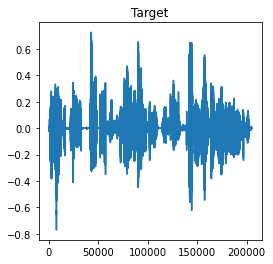

In [17]:
plt.figure()
plt.title('Target')
plt.plot(targets)

Audio(targets, rate=16000)

Reference sound clip:

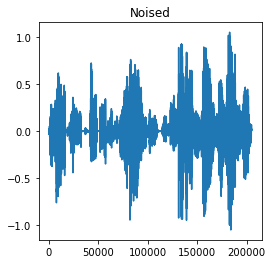

In [18]:
plt.figure()
plt.title('Noised')
plt.plot(noised)

Audio(noised, rate=16000)

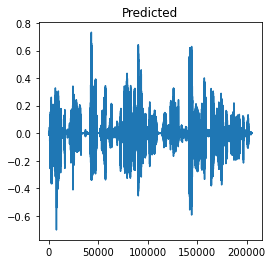

In [19]:
plt.figure()
plt.title('Predicted')
plt.plot(refs)

Audio(refs, rate=16000)

Text(0.5, 1.0, 'Noisy')

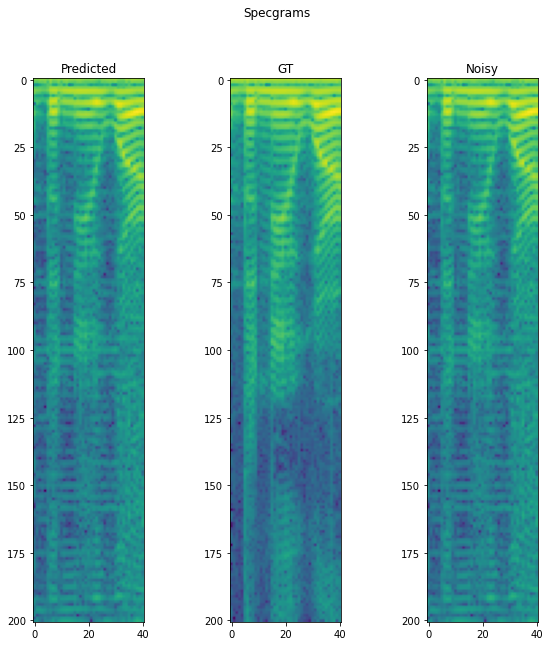

In [53]:
specgram = torchaudio.transforms.Spectrogram()(torch.tensor(ref).T)
target_specgram = torchaudio.transforms.Spectrogram()(torch.tensor(target).T)
noised_specgram = torchaudio.transforms.Spectrogram()(torch.tensor(noised).T)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

fig, axs = plt.subplots(1, 3)
fig.suptitle('Specgrams')
axs[0].imshow(specgram.log2().numpy())
axs[0].set_title('Predicted')
axs[1].imshow(target_specgram.log2().numpy())
axs[1].set_title('GT')
axs[2].imshow(specgram.log2().numpy())
axs[2].set_title('Noisy')